# Machine Learning Engineer Nanodegree
## Capstone Project: Segmentation of Credit Card Holders

James Wanderi Kinyanjui
July 29, 2019

---

The project is based on the [proposal](https://github.com/wanderijames/credit-card-customer/blob/master/proposal.pdf) submitted for this Nanodegree program.

We will be using the [Kaggle data](https://www.kaggle.com/arjunbhasin2013/ccdata) for this project. Our goal is to create clusters of the card holders using unsupervised learning technique and then used supervised learning in assigning groups to new card holders.

# Load data

In [1]:
# Import libraries necessary for this project
import random
import warnings
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

from feature_relevance import cc_feature_relevance

# Pretty display for notebooks
%matplotlib inline

# Reproduce random-ability
random.seed(0)

# Ignore warnings
warnings.simplefilter("ignore")

try:
    raw_data = pd.read_csv("ccdata.zip")
    raw_data_rows, raw_data_columns = raw_data.shape
    print("Our dataset has {} samples with {} features each.".format(raw_data_rows, raw_data_columns))
except Exception as err:
    print("Dataset could not be loaded. Is the dataset missing? {}".format(err))

Our dataset has 8950 samples with 18 features each.


# Data Exploration

In this section we are going to undertstand our dataset.

Specifically, we will find which features are important to finding our solution to the problem.

---

In [2]:
# Display a description of the dataset
display(raw_data.describe())

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083333   
50%                 89.000000      0.000000             0.500000   
75%                468.637500   1113.821139             0.916667   
max              22500.000000  47137.211760             1.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8950.000000                       8950.000000   
mean                     0.202458                          0.364437   
std                      0.298336                          0.397448   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083333                          0.166667   
75%                      0.300000                          0.750000   
max                      1.000000                          1.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8950.000000       8950.000000    8950.000000   8949.000000   
mean                 0.135144          3.248827      14.709832   4494.449450   
std                  0.200121          6.824647      24.857649   3638.815725   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.222222          4.000000      17.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count   8950.000000       8637.000000       8950.000000  8950.000000  
mean    1733.143852        864.206542          0.153715    11.517318  
std     2895.063757       2372.446607          0.292499     1.338331  
min        0.000000          0.019163          0.000000     6.000000  
25%      383.276166        169.123707          0.000000    12.000000  
50%      856.901546        312.343947          0.000000    12.000000  
75%     1901.134317        825.485459          0.142857    12.000000  
max    50721.483360      76406.207520          1.000000    12.000000

Note how some features' standard deviation are greater than the mean, e.g BALANCE, PURCHASES

This clearly shows how the data varies and may create very distinct set of clusters.

The clusters could present the **high-income-earners**, **middle-income-earners** and **low-income-earners**.

--

## Selecting Samples

Lets select few data that we use to track some transformations that will be carried throughout our solution.

--

In [3]:
np.random.seed(1485756873)
sample_indices = sorted(np.random.choice(raw_data_rows, 5, replace=False).tolist())[:3]
print("Our selected samples indeces are:\n\n ", sample_indices)

# Create a DataFrame
samples = pd.DataFrame(raw_data.loc[sample_indices], columns = raw_data.keys()).reset_index(drop = True)
print("\nChosen samples transaction dataset:")
display(samples)

Our selected samples indeces are:

  [275, 5424, 5533]

Chosen samples transaction dataset:


CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10286     2.564117           0.181818      47.95             47.95   
1  C15577  1039.256129           1.000000     618.75              0.00   
2  C15689    30.395073           1.000000     512.47            512.47   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    0.00           0.0             0.083333   
1                  618.75           0.0             0.916667   
2                    0.00           0.0             1.000000   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.083333                          0.000000   
1                    0.000000                          0.916667   
2                    1.000000                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                     0.0                 0              1        1500.0   
1                     0.0                 0             11        1700.0   
2                     0.0                 0             12        7000.0   

     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0  294.507498         86.245988               0.0      12  
1  202.137436        262.204840               0.0      12  
2  484.669932        192.908611               1.0      12

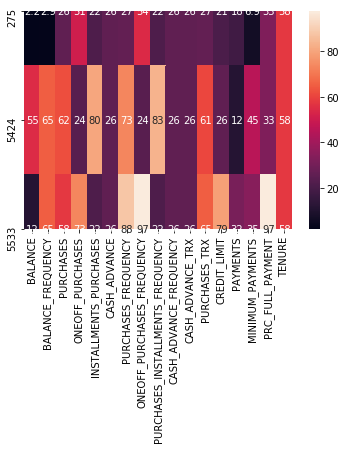

In [4]:
import seaborn as sns

raw_data_without_id = raw_data.copy()
raw_data_without_id.drop(["CUST_ID"], axis=1, inplace=True)

percentiles_data = 100 * raw_data_without_id.rank(pct=True)
percentiles_samples = percentiles_data.iloc[sample_indices]
sns.heatmap(percentiles_samples, annot=True)

Generally, our sample customers do not pay cash in advance for their purchases.

**Sample 275**

Spends very little and doesn't have much balance in their card maybe due to lower credit limit. This customer could be categrorized as low-income-earner.

**Sample 5524**

This customer is a big spender with low credit limit. The customer has high balance available for spending because he/she prefers purchases in installments and regularly repays the credit issues in installments as well. So this customer can be categorized as middle-income-earner

**Sample 5533**

This customer is not a big spender but can be categorized as high-income-earner. The customer doesn't purchase in installments and regularly pays back the card issuer. This customer has very high credit limit due to their ability to repay the credit. Often than not, the bank gives high credit limit when one can show high source of income or asset value

## Feature Relevance

We will try to identify which features are relevant.

We will start by prediciting a feature using other features. The prediction score, R2, will inform us about the feature importance.

--

In [5]:
# Calculate feature-feature relavance
feature_df = cc_feature_relevance(raw_data)

In [6]:
# See feature-feature relavance
feature_df.sort_values(by="_score", ascending=False)

_predicted_feature    _score   BALANCE  BALANCE_FREQUENCY  \
6                PURCHASES_FREQUENCY  0.991076  0.000664           0.000543   
2                          PURCHASES  0.973449  0.001652           0.001118   
8   PURCHASES_INSTALLMENTS_FREQUENCY  0.964335  0.002534           0.000258   
3                   ONEOFF_PURCHASES  0.958696  0.004510           0.000063   
0                            BALANCE  0.929095  0.000000           0.009159   
7         ONEOFF_PURCHASES_FREQUENCY  0.905090  0.009500           0.000836   
4             INSTALLMENTS_PURCHASES  0.857005  0.003768           0.006803   
9             CASH_ADVANCE_FREQUENCY  0.856828  0.019427           0.007383   
5                       CASH_ADVANCE  0.754408  0.045624           0.018359   
1                  BALANCE_FREQUENCY  0.726351  0.214835           0.000000   
16                            TENURE  0.704620  0.051353           0.332340   
13                          PAYMENTS  0.700375  0.037355           0.035209   
11                     PURCHASES_TRX  0.688724  0.032169           0.002123   
10                  CASH_ADVANCE_TRX  0.679318  0.024147           0.008052   
15                  PRC_FULL_PAYMENT  0.640739  0.371799           0.022561   
12                      CREDIT_LIMIT  0.486310  0.391555           0.014505   
14                  MINIMUM_PAYMENTS  0.429189  0.298759           0.014027   

    PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  \
6    0.005881          0.000856                0.001824      0.000283   
2    0.000000          0.793856                0.179984      0.000028   
8    0.003523          0.004699                0.750951      0.000820   
3    0.836774          0.000000                0.083786      0.000331   
0    0.003304          0.002516                0.004324      0.005228   
7    0.008955          0.652447                0.020186      0.002598   
4    0.568401          0.206284                0.000000      0.000741   
9    0.004008          0.003935                0.004257      0.047537   
5    0.009451          0.010673                0.007762      0.000000   
1    0.026761          0.010620                0.011750      0.036418   
16   0.017513          0.014777                0.009693      0.030314   
13   0.375216          0.047988                0.027391      0.242029   
11   0.560861          0.030643                0.036459      0.006483   
10   0.008075          0.004949                0.011009      0.093891   
15   0.099523          0.014205                0.029506      0.013128   
12   0.121097          0.041578                0.036436      0.046324   
14   0.040261          0.009637                0.108901      0.011306   

    PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
6              0.000000                    0.061139   
2              0.000117                    0.000169   
8              0.189565                    0.025022   
3              0.000329                    0.033267   
0              0.001105                    0.001752   
7              0.184960                    0.000000   
4              0.001219                    0.020426   
9              0.002062                    0.004250   
5              0.005457                    0.007989   
1              0.148325                    0.006976   
16             0.030886                    0.028191   
13             0.005996                    0.007137   
11             0.156396                    0.030964   
10             0.005573                    0.006508   
15             0.077475                    0.009690   
12             0.014074                    0.027574   
14             0.020732                    0.006604   

    PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  \
6                           0.121011                0.000236   
2                           0.000183                0.000259   
8                           0.000000                0.000371   
3                           0.003


From the above table, we see that `PURCHASES_FREQUENCY` is the mostly predicted by the other features. However, `PURCHASES_TRX` appears to be the only relevant feature in prediciting `PURCHASES_FREQUENCY`.


## Feature Distribution

Let us look at the correlation of the features. We expect to see `PURCHASES_FREQUENCY` to be highly correlated with the other features.

--

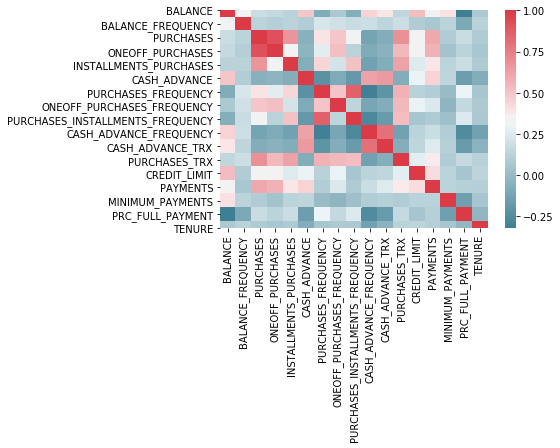

In [7]:
import seaborn as sns

sns.heatmap(raw_data.corr(), cmap=sns.diverging_palette(220, 10, as_cmap=True))

From the table above and as confirmed by the graph above, you will see that utmost 4 features are relevant in prediciting another feature. An example is seen with `CASH_ADVANCE`, `INSTALLMENTS_PURCHASES`, `ONE-OFF_PURCHASES` and `PURCHASES` being relevant in predicting `PAYMENTS`

From an early observation, we cannot use all the feautures in our solution to the problem. We will have to carry further analysis in selecting important features for clusteting. 

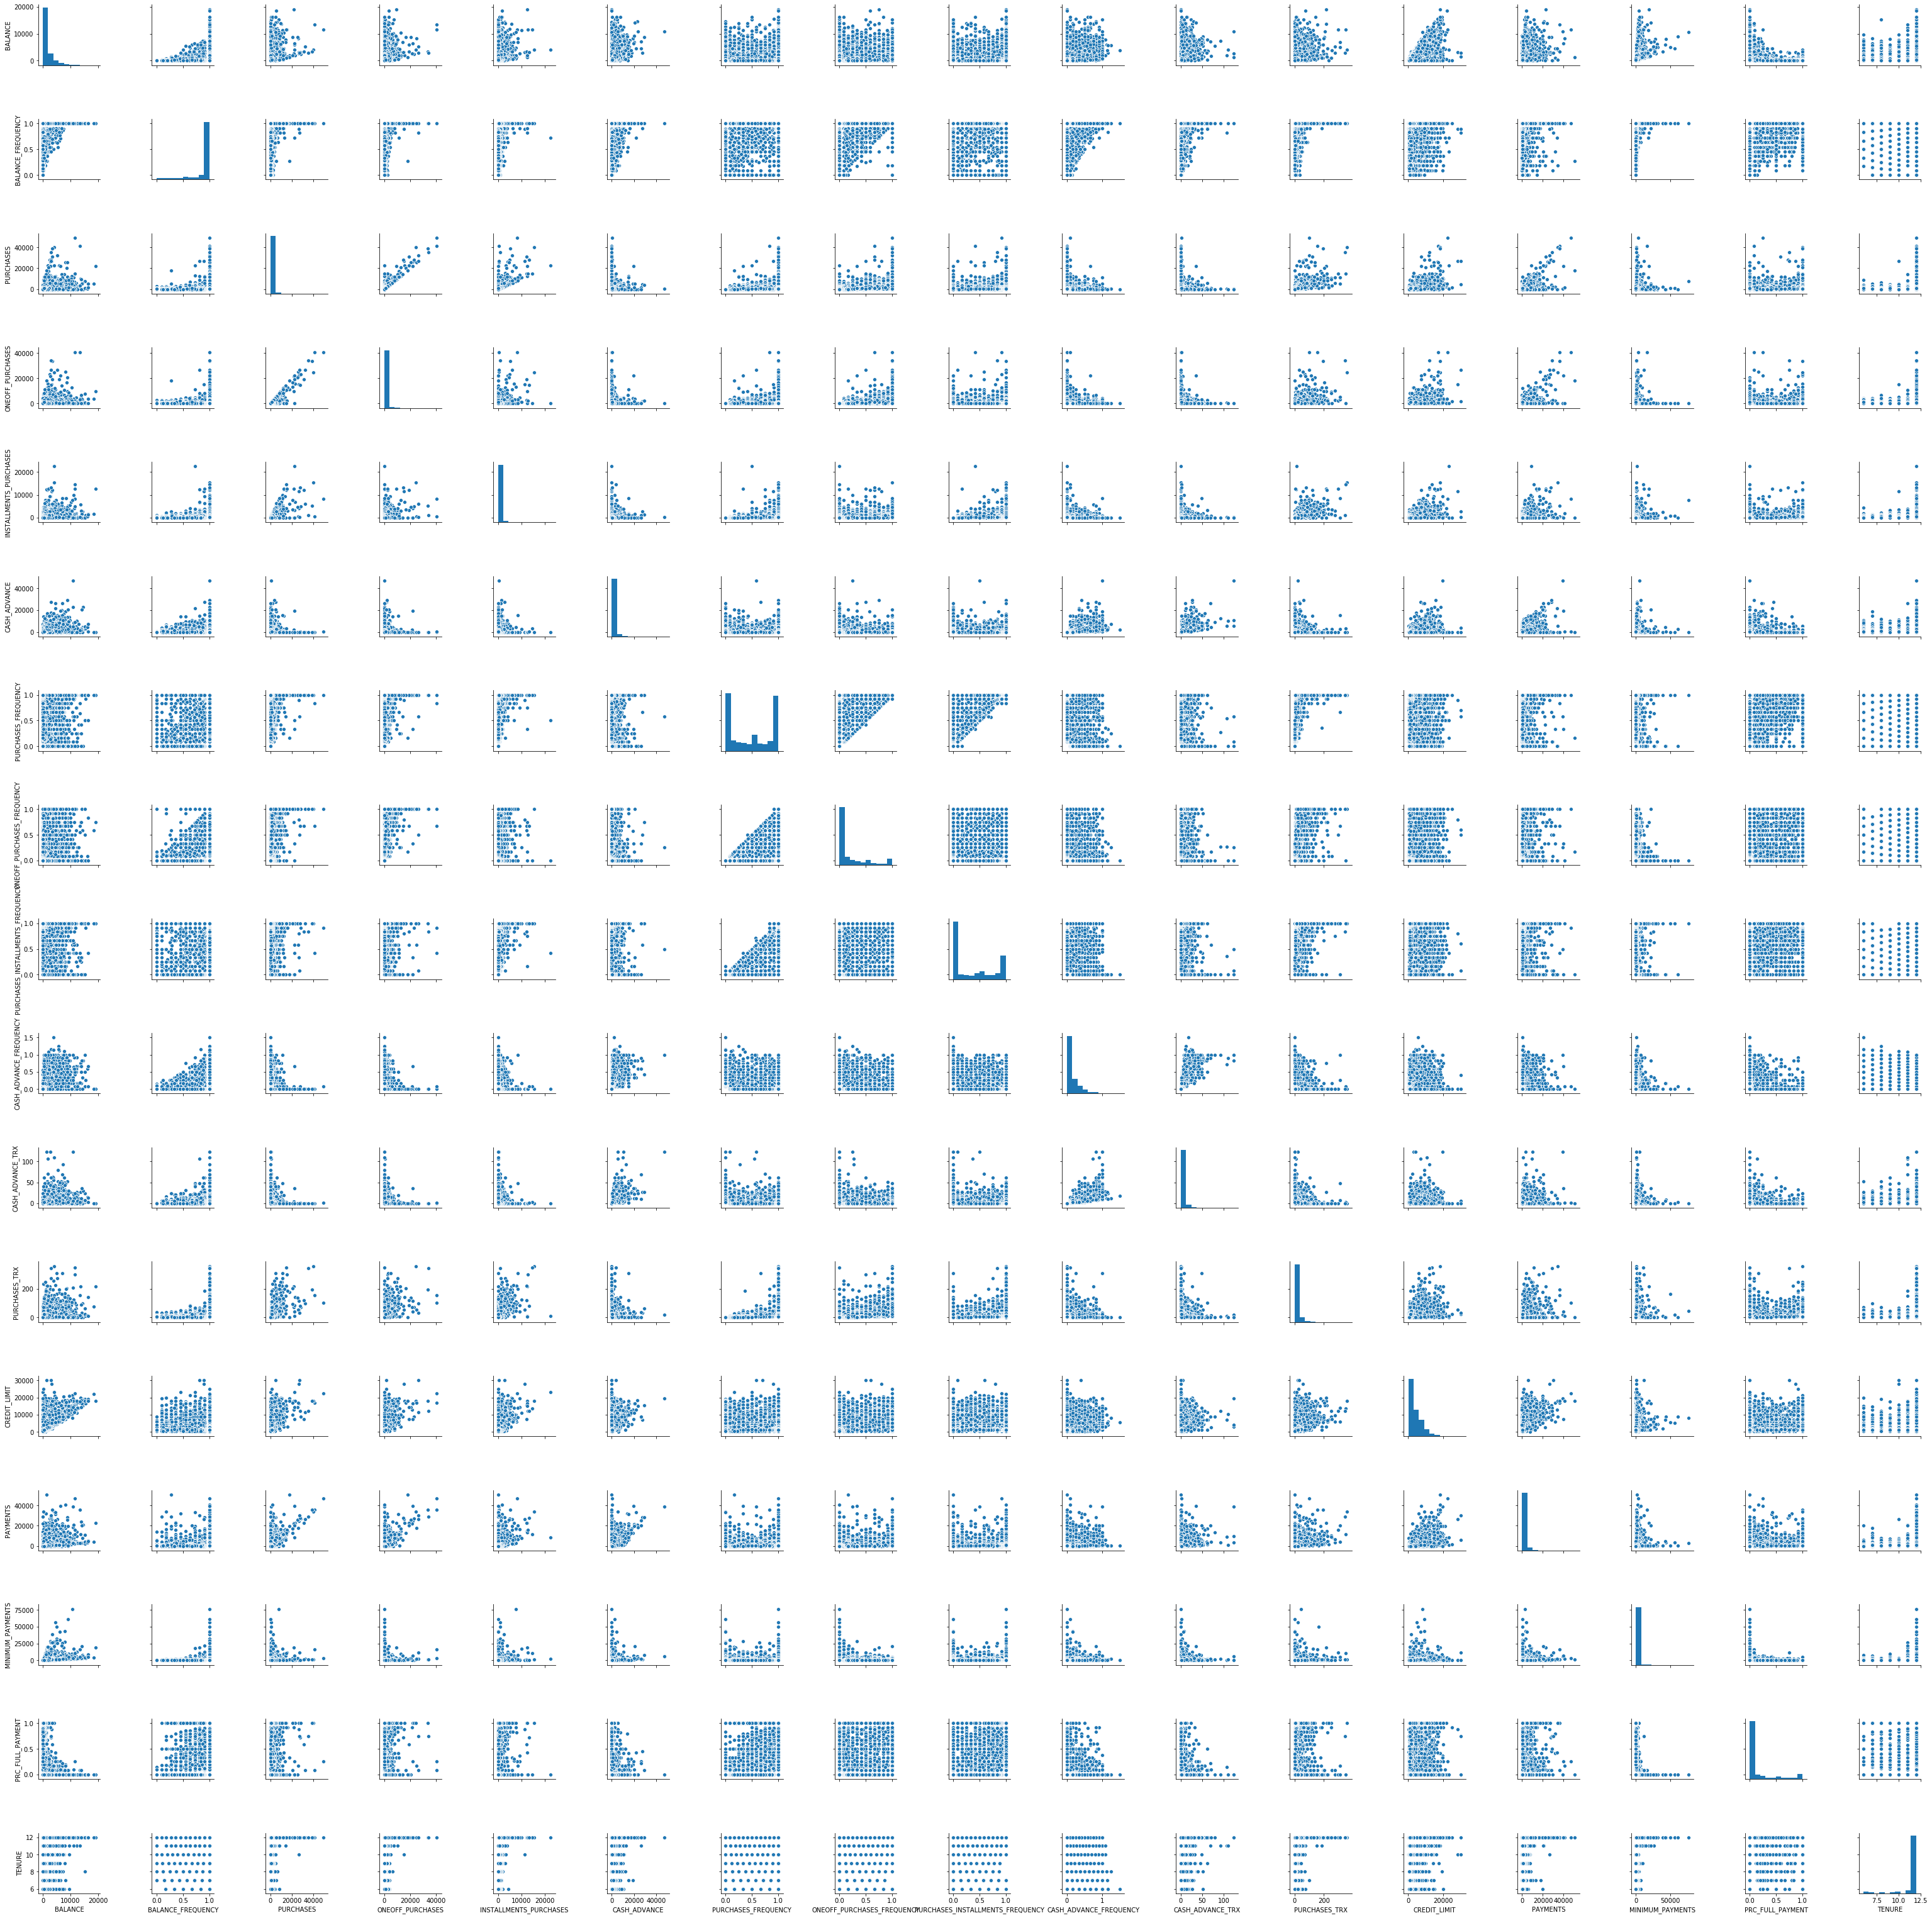

In [8]:
g = sns.pairplot(raw_data)

Concentration of data points around the origin i.e point-zero shows that the pair-feature are not correlated.

Furthermore, graphs showing evenly distributed data points all over the plot area show non-correlation between the pairs. A good example is paring `PRC_FULL_PAYMENT` with either `PURCHASES_FREQUENCY`, `ONEOFF_PURCHASES_FREQUENCY`, `PURCHASES_INSTALLMENTS_FREQUENCY`, `CASH_ADVANCE_FREQUENCY` or `TENURE`

Good examples of correlation is pairing `PURCHASES` with either `BALANCE`, `BALANCE_FREQUENCY`, `ONEOFF_PURCHASES`, `INSTALLMENTS_PURCHASES`, `PURCHASES_TRX`, `CREDIT_LIMIT` or `PAYMENTS`. You will also see that `PURCHASES` can be easily predicted by other features. The features that correlate well with `PURCHASES` have high score in feature importance.

# Data Preprocessing

The correlation above needs to be refined. A better way to do this is to scale the data and remove outliers. This will ensure that our results are significant and meaningful.

Since data is not normally distributed, i.e the mean and median vary significantly (indicating a large skew), we will apply a non-linear scaling using [Yeo-Johnson](https://academic.oup.com/biomet/article-abstract/87/4/954/232908)[1] (I.K. Yeo and R.A. Johnson, 2000) transformation that reduces skewness.

I would have used [Box-Cox](https://www.jstor.org/stable/2984418) [2] transformation but our data that has zeros. Yeo-Johnson transformation is able to transform data that zeros and negative numbers.

[1] Yeo and R.A. Johnson, “A new family of power transformations to improve normality or symmetry.” Biometrika, 87(4), pp.954-959, (2000)

[2] G.E.P. Box and D.R. Cox, “An Analysis of Transformations”, Journal of the Royal Statistical Society B, 26, 211-252 (1964)

--

In [9]:
# from sklearn.preprocessing import PowerTransformer

# pt = PowerTransformer(method="yeo-johnson", standardize=True)
# scaled_data_ndarray = pt.fit_transform(raw_data_without_id)
# scaled_data = pd.DataFrame.from_records(scaled_data_ndarray, columns=raw_data_without_id.columns)
# scaled_data = np.log(raw_data_without_id)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(raw_data_without_id.values)
scaled_data = pd.DataFrame(scaled_features, index=raw_data_without_id.index, columns=raw_data_without_id.columns)



In [10]:
scaled_data.describe()

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count  8.950000e+03       8.950000e+03  8.950000e+03      8.950000e+03   
mean  -2.540488e-17       1.587805e-16  3.175610e-18     -6.033659e-17   
std    1.000056e+00       1.000056e+00  1.000056e+00      1.000056e+00   
min   -7.516398e-01      -3.703271e+00 -4.695519e-01     -3.569340e-01   
25%   -6.900078e-01       4.904486e-02 -4.510006e-01     -3.569340e-01   
50%   -3.320286e-01       5.180838e-01 -3.004541e-01     -3.340396e-01   
75%    2.352559e-01       5.180838e-01  5.004652e-02     -9.056763e-03   
max    8.397489e+00       5.180838e-01  2.248351e+01      2.420107e+01   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count            8.950000e+03  8.950000e+03         8.950000e+03   
mean             3.175610e-17 -4.763415e-18         9.010793e-17   
std              1.000056e+00  1.000056e+00         1.000056e+00   
min             -4.545762e-01 -4.667856e-01        -1.221758e+00   
25%             -4.545762e-01 -4.667856e-01        -1.014125e+00   
50%             -3.561562e-01 -4.667856e-01         2.404259e-02   
75%              6.366321e-02  6.435242e-02         1.062211e+00   
max              2.442689e+01  2.201112e+01         1.269843e+00   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                8.950000e+03                      8.950000e+03   
mean                 1.905366e-17                      5.716098e-17   
std                  1.000056e+00                      1.000056e+00   
min                 -6.786608e-01                     -9.169952e-01   
25%                 -6.786608e-01                     -9.169952e-01   
50%                 -3.993193e-01                     -4.976286e-01   
75%                  3.269728e-01                      9.701506e-01   
max                  2.673451e+00                      1.599199e+00   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count            8.950000e+03      8.950000e+03   8.950000e+03  8.949000e+03   
mean            -1.635439e-16     -1.746585e-17  -1.905366e-17  1.905579e-16   
std              1.000056e+00      1.000056e+00   1.000056e+00  1.000056e+00   
min             -6.753489e-01     -4.760698e-01  -5.917959e-01 -1.221468e+00   
25%             -6.753489e-01     -4.760698e-01  -5.515646e-01 -7.954817e-01   
50%             -6.753489e-01     -4.760698e-01  -3.101767e-01 -4.107196e-01   
75%              4.351492e-01      1.100739e-01   9.213645e-02  5.511855e-01   
max              6.820521e+00      1.754785e+01   1.381101e+01  7.009692e+00   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT        TENURE  
count  8.950000e+03      8.637000e+03      8.950000e+03  8.950000e+03  
mean   3.493171e-17     -2.303485e-17     -1.270244e-17  2.921561e-16  
std    1.000056e+00      1.000058e+00      1.000056e+00  1.000056e+00  
min   -5.986883e-01     -3.642811e-01     -5.255510e-01 -4.122768e+00  
25%   -4.662913e-01     -2.929984e-01     -5.255510e-01  3.606795e-01  
50%   -3.026846e-01     -2.326268e-01     -5.255510e-01  3.606795e-01  
75%    5.802976e-02     -1.632211e-02     -3.712234e-02  3.606795e-01  
max    1.692228e+01      3.184323e+01      2.893453e+00  3.606795e-01

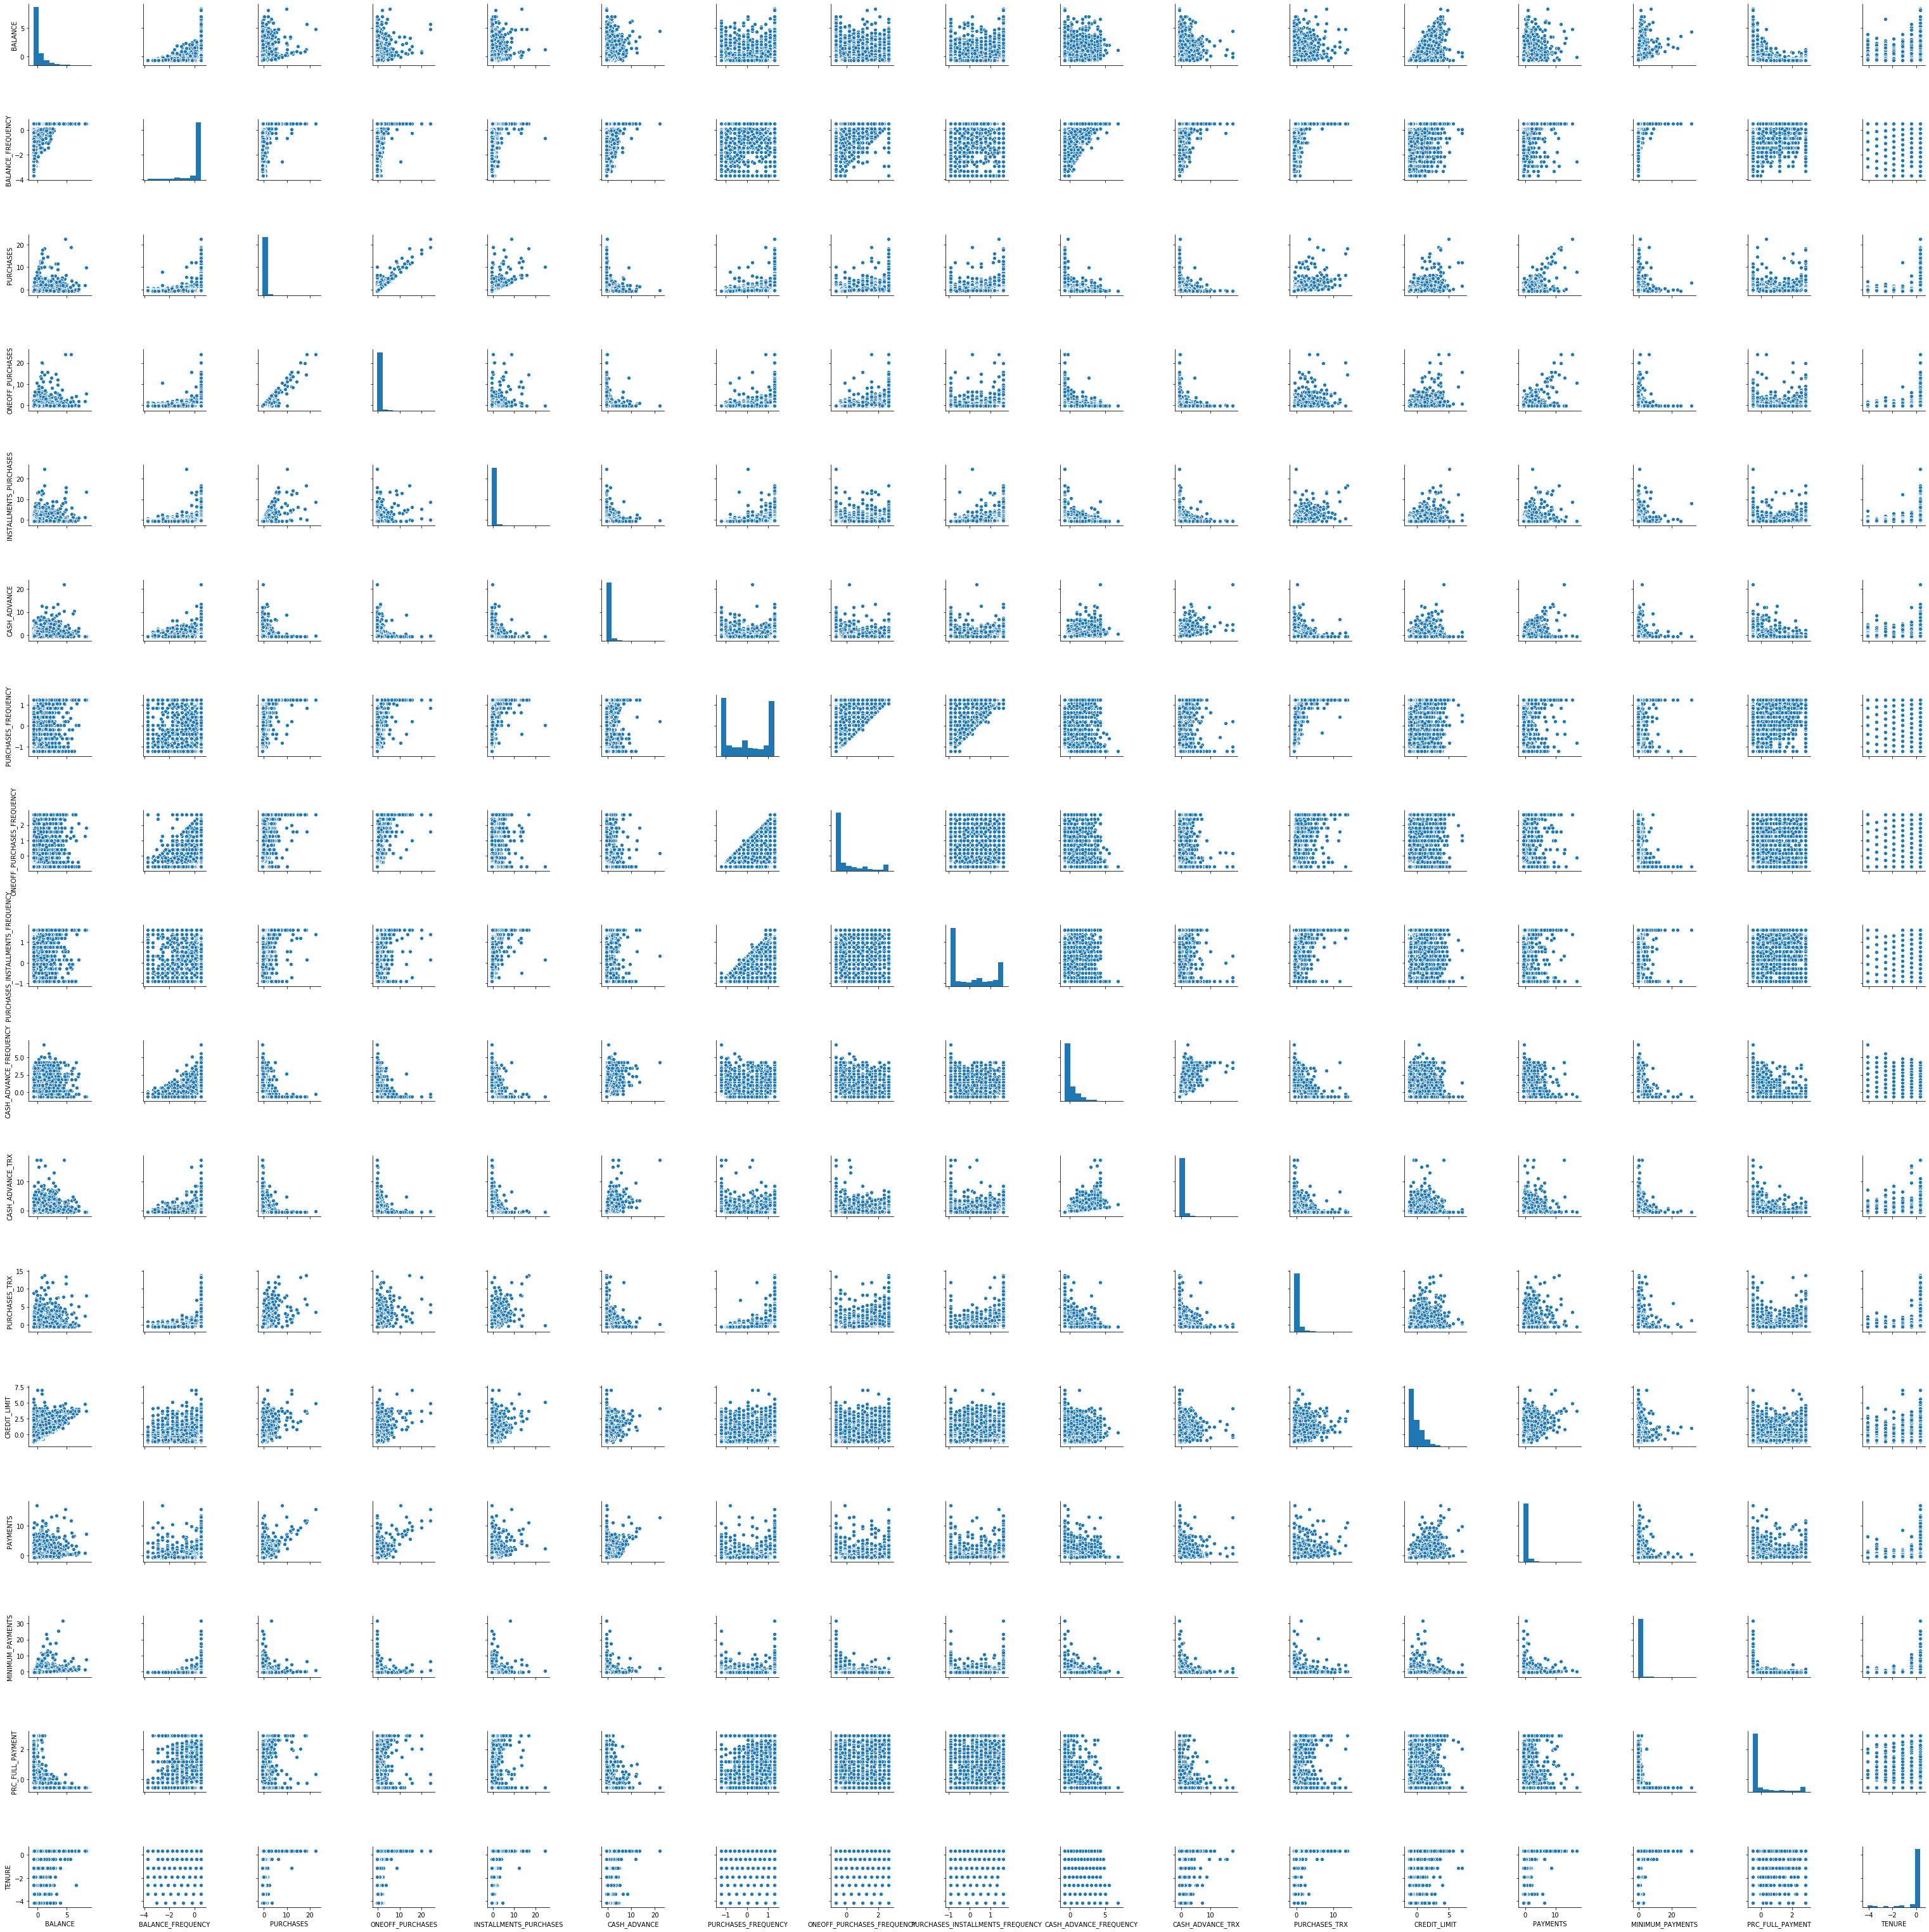

In [11]:
h = sns.pairplot(scaled_data)

In [228]:
# Lets view the scaled data of the samples
samples_scaled = pd.DataFrame(scaled_data.loc[sample_indices], columns = scaled_data.keys()).reset_index(drop = True)
# samples_scaled.insert(0, "CUST_ID", samples["CUST_ID"])
print("\nChosen samples transaction dataset:")
display(samples_scaled)


Chosen samples transaction dataset:


BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -0.750408          -2.935753  -0.447109         -0.328045   
1 -0.252337           0.518084  -0.179945         -0.356934   
2 -0.737037           0.518084  -0.229689         -0.048179   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -0.454576     -0.466786            -1.014125   
1                0.229664     -0.466786             1.062211   
2               -0.454576     -0.466786             1.269843   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.399319                         -0.916995   
1                   -0.678661                          1.389517   
2                    2.673451                         -0.916995   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0               -0.675349          -0.47607      -0.551565     -0.822965   
1               -0.675349          -0.47607      -0.149251     -0.767999   
2               -0.675349          -0.47607      -0.109020      0.688601   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT   TENURE  
0 -0.496955         -0.327934         -0.525551  0.36068  
1 -0.528863         -0.253762         -0.525551  0.36068  
2 -0.431266         -0.282972          2.893453  0.36068

## Outliers detection and removal

This forms an integral part of data pre-processing. We remove data that tend to skew the distribution of data. The presence of the data points may lead to skewed results. K-Means clustering is very sensitive to outliers. Therefore, it is important we can remove the outliers from our data if we intend to use K-Means as our benchmark model.

In [230]:
import outliers as otl

outliers_, outliers_count_ = otl.detect(scaled_data)

print("Rows that are outliers: ", len(outliers_), "\n")

print("Feature rows that are outliers:\n")
for feat, count in outliers_count_.items():
    print("\t{}: {}".format(feat, count))

NameError: name 'np' is not defined

In [25]:
# Check if our samples are among the outliers
for index in sample_indices:
    if index in outliers_:
        print("Index {} is an outlier".format(index))

In [29]:
# Remove outliers from our data
good_data = scaled_data.drop(scaled_data.index[outliers_]).reset_index(drop = True)

# I think we can disregard `CREDIT_LIMIT` and `MINIMUM_PAYMENTS` since their data points seem unrelated
good_data.drop(['CREDIT_LIMIT', 'MINIMUM_PAYMENTS'], axis=1, inplace=True)

# Feature Transformation

We are going to transform our data into few dimensions that maximize variance. We will do this by implementing PCA

--

## PCA

Principal Component Analysis (PCA) is a method used in dimensionality reduction. Many variables are reduced into few while containing much information in them.

Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process (Zakaria Jaadi). [1]

[1] Zakaria Jaadi. A step by step explanation of Principal Component Analysis. Feb 28, 2019. [https://towardsdatascience.com/a-step-by-step-explanation-of-principal-component-analysis-b836fb9c97e2] Accessed on Aug 1, 2019.

In [139]:
import visuals as vs

In [85]:
from sklearn.decomposition import PCA
pca = PCA(n_components=good_data.shape[1])
pca.fit(good_data)

# TODO: Transform samples data using the PCA fit above
samples_scaled_2 = samples_scaled.drop(['CREDIT_LIMIT', 'MINIMUM_PAYMENTS'], axis=1)
pca_samples = pca.transform(samples_scaled_2)

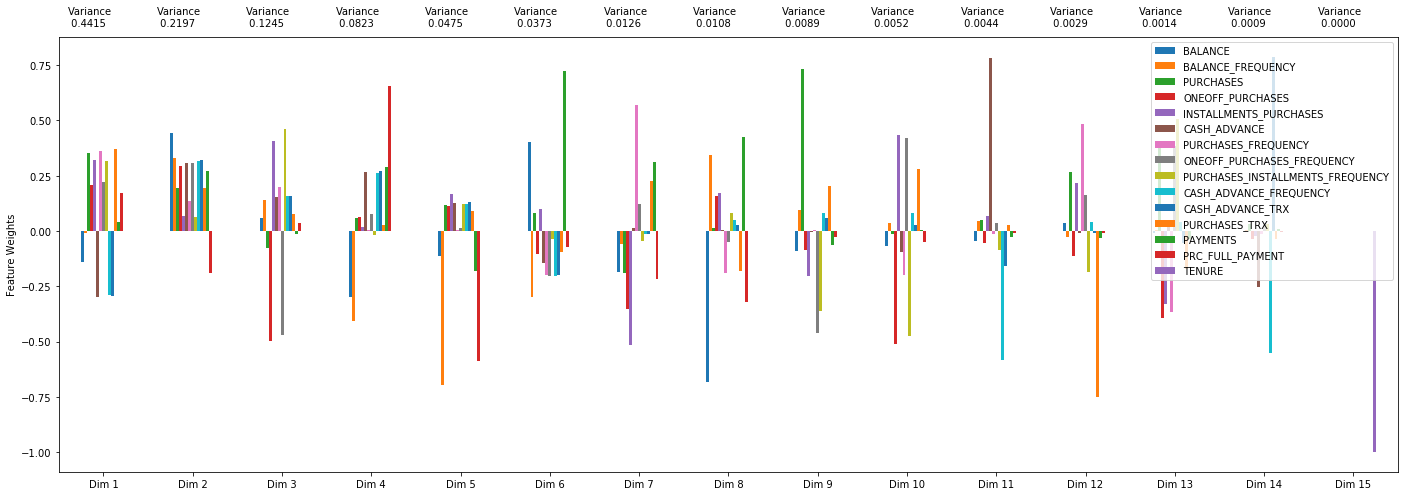

In [141]:
# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

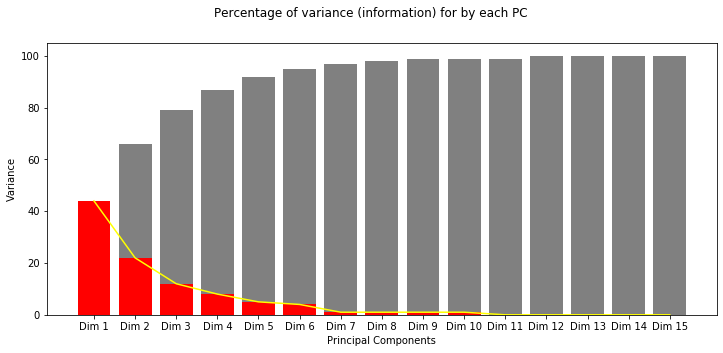

In [140]:
vs.pc_variance(pca_results)

### Observation

In [52]:
# Display sample data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

Dimension 1  Dimension 2  Dimension 3  Dimension 4  Dimension 5  \
0      -0.7403      -3.0123      -2.0816      -0.0249       1.4543   
1       1.4587      -0.8694       1.7875      -1.8334       0.1460   
2       1.7863      -0.7886      -2.3045       0.7961      -1.6440   

   Dimension 6  Dimension 7  Dimension 8  Dimension 9  Dimension 10  \
0      -0.0796       0.2007       0.5118      -0.0862       -0.1434   
1      -0.1818       0.0372      -0.3970       0.2331       -0.1104   
2      -1.5280       0.8844      -0.3055       0.0729        0.1325   

   Dimension 11  Dimension 12  Dimension 13  Dimension 14  Dimension 15  
0       -0.0960       -0.0703       -0.0068       -0.0032           0.0  
1       -0.0349        0.2632        0.1037        0.0107           0.0  
2        0.0378        0.3606       -0.2374       -0.0049           0.0

### Dimensionality Reduction

In [142]:
pca = PCA(n_components=2)
pca.fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform sample data using the PCA fit above
pca_samples2 = pca.transform(samples_scaled_2)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ["Dimension {}".format(x + 1) for x in range(2)])

In [143]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples2, 6), columns = ["Dimension {}".format(x + 1) for x in range(2)]))

Dimension 1  Dimension 2
0    -0.740307    -3.012299
1     1.458672    -0.869428
2     1.786348    -0.788649

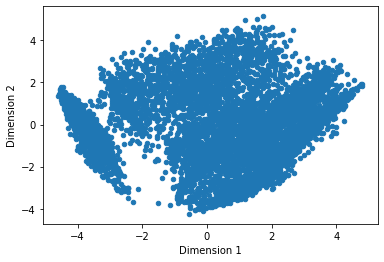

In [144]:
# Visualize reduced data
reduced_data.plot.scatter(x="Dimension 1", y="Dimension 2")

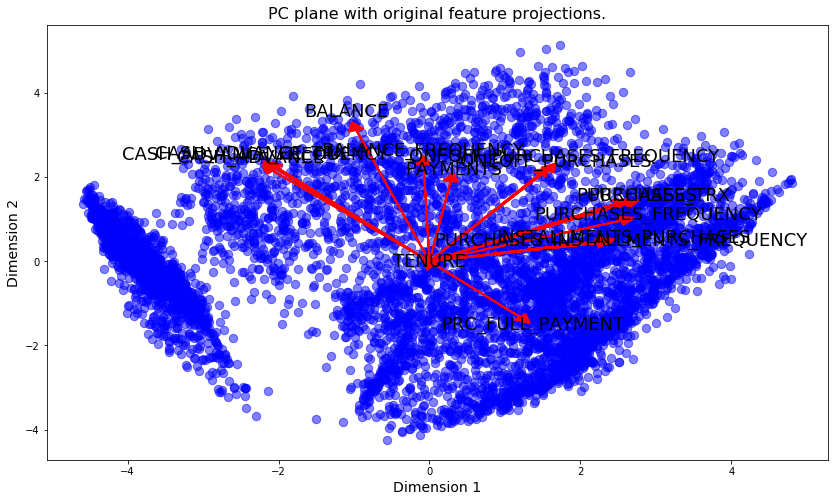

In [145]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

## Clustering

In [160]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_cluster_trials = range(2, 6)

def get_cluster_and_score(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(reduced_data)
    pred = kmeans.predict(reduced_data)
    score = silhouette_score(
        reduced_data, pred)
    return score

trials = {x: get_cluster_and_score(x) for x in n_cluster_trials}

display(pd.DataFrame(
    data={"Cluster {}".format(x): [y] for x,y in trials.items()},
    index=["Scores"]
))

print("Severals KMeans scores with different n_clusters\n")
print(trials)
print("`n_clusters=2` scored the highest\n")

clusterer = KMeans(n_clusters=3)
clusterer.fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
centers = clusterer.cluster_centers_

# TODO: Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples2)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)

print("centers", centers, "\n")

print("sample_preds", sample_preds, "\n")

print("pca_samples", pca_samples, "\n")

Cluster 2  Cluster 3  Cluster 4  Cluster 5
Scores   0.471758   0.453311   0.468311   0.433232

Severals KMeans scores with different n_clusters

{2: 0.4717576100770621, 3: 0.45331112093147913, 4: 0.4683113828709763, 5: 0.4332320925043257}
`n_clusters=2` scored the highest

centers [[ 1.74275572  1.5071816 ]
 [-3.20544208  0.22323415]
 [ 1.03072495 -1.61837365]] 

sample_preds [2 2 2] 

pca_samples [[-7.40307251e-01 -3.01229938e+00 -2.08156743e+00 -2.49274506e-02
   1.45428876e+00 -7.96006034e-02  2.00701864e-01  5.11846941e-01
  -8.62037737e-02 -1.43428643e-01 -9.60178901e-02 -7.03086274e-02
  -6.78622524e-03 -3.17805555e-03  1.11022302e-16]
 [ 1.45867230e+00 -8.69427964e-01  1.78747884e+00 -1.83344975e+00
   1.46029672e-01 -1.81806852e-01  3.71624669e-02 -3.96984590e-01
   2.33059438e-01 -1.10369365e-01 -3.49122643e-02  2.63223096e-01
   1.03742247e-01  1.07158929e-02  1.11022302e-16]
 [ 1.78634793e+00 -7.88648561e-01 -2.30448093e+00  7.96107790e-01
  -1.64402403e+00 -1.52799876e+00  8.84369875e-01 -3.05516489e-01
   7.28805597e-02  1.32458389e-01  3.78406664e-02  3.60568455e-0

In [214]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

alg = DBSCAN(eps=0.25)
cluster_labels = alg.fit_predict(reduced_data)
y_pred = alg.labels_
print(silhouette_score(reduced_data, y_pred))
print({x for x in cluster_labels})

# def get_cluster_and_score_cls(clf: tuple) -> list:
#     result = []
#     for algorithm in clf:
#         algorithm.fit(reduced_data)
#         if hasattr(algorithm, 'labels_'):
#             y_pred = algorithm.labels_.astype(np.int)
#         else:
#             y_pred = algorithm.predict(X)
#         score = silhouette_score(reduced_data, y_pred)
#         result.append(score)
#     return result

# n_cluster_trials = range(2, 6)
# def get_clfs(n_clusters: int) -> dict:
#     return (
#         DBSCAN(eps=0.25),
#        KMeans(n_clusters),
#     )

# ctrials = {x: get_cluster_and_score_cls(get_clfs(x)) for x in n_cluster_trials}

# display(pd.DataFrame(
#     data={"Cluster {}".format(x): y for x,y in ctrials.items()},
#     index=["DBSCAN", "K-Means"]
# ))

0.1341908817040374
{0, 1, 2, -1}


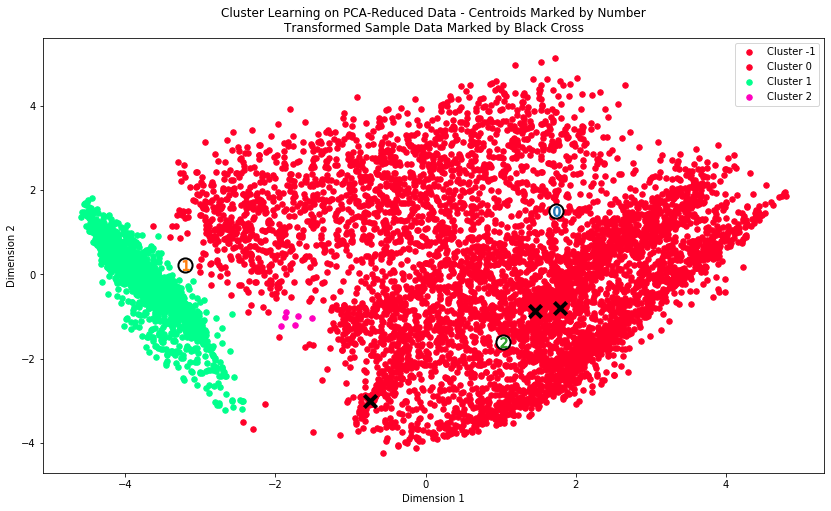

In [215]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, y_pred, centers, pca_samples2)

Automatically created module for IPython interactive environment


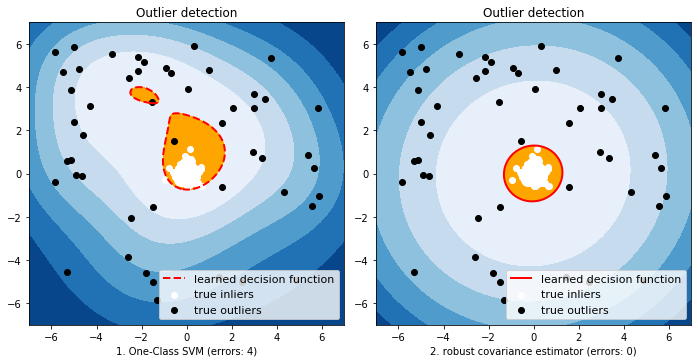

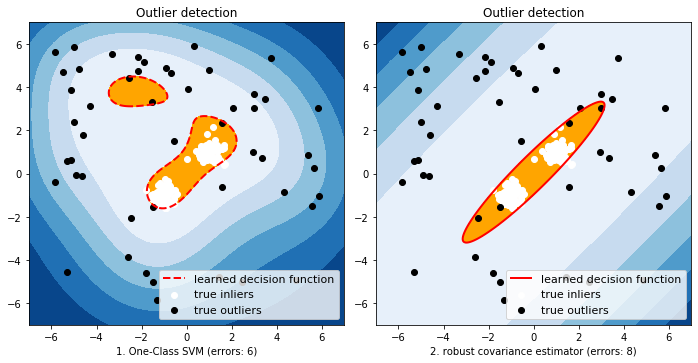

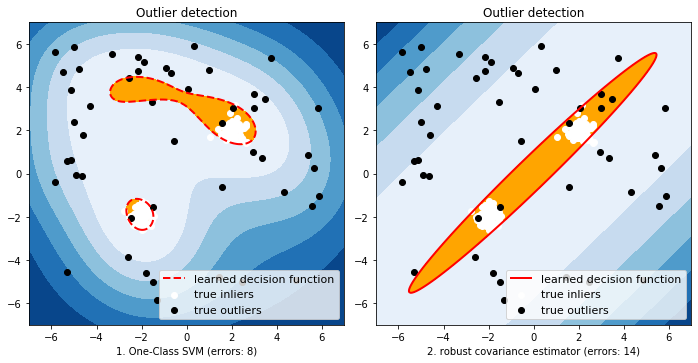

In [123]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from scipy import stats

from sklearn import svm
from sklearn.covariance import EllipticEnvelope

# Example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

# define two outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "robust covariance estimator": EllipticEnvelope(contamination=.1)}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = 0

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(int(0.5 * n_inliers), 2) - offset
    X2 = 0.3 * np.random.randn(int(0.5 * n_inliers), 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model with the One-Class SVM
    plt.figure(figsize=(10, 5))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        clf.fit(X)
        y_pred = clf.decision_function(X).ravel()
        threshold = stats.scoreatpercentile(y_pred,
                                            100 * outliers_fraction)
        y_pred = y_pred > threshold
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(1, 2, i + 1)
        subplot.set_title("Outlier detection")
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=11))
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)

plt.show()